<div>
    <img style="float:right;" src="images/smi-logo.png"/>
    <div style="float:left;color:#58288C;"><h1>Datenanalyse und Datenmanagement</h1></div>
</div>

---
# Notebook III: Data Exploration
In diesem Notebook geht es um die Verwendung von Python zur Erkundung eines eingelesenen Datenbestands.  
Hierzu werden einfache statistische Techniken und Visualisierungsformen eingesetzt.

## Inhaltsverzeichnis

[1. Daten einlesen und aufbereiten](#kapitel1)  
[2. Merkmale untersuchen und visualisieren](#kapitel2)  
[3. Zusammenhänge untersuchen und visualisieren](#kapitel3)  
[4. Anwendungsbeispiel Minecraft Kernbohrung](#kapitel4)  
[5. Anwendungsbeispiel Kreditvergabe](#kapitel5)  

---

## 1. Daten einlesen und aufbereiten <a id="kapitel1"/>

### 1.1. DataFrames und grobe Datenvalidierung
Pandas sind das zentrale Werkzeug zum einlesen und manipulieren von Daten in Python. Für unsere Zwecke ist die Datenstruktur des ```DataFrames``` am wichtigsten:

> **DataFrame** is a 2-dimensional labeled data structure with columns of potentially different types.  
> You can think of it like a spreadsheet or SQL table [...]. It is generally the most commonly used pandas object.  
> [(Quelle)](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html)

Dataframes haben demnach Zeilen ("Rows") und Spalten ("Columns") können zudem einen Index haben - ein datensatzidentifizierendes Merkmal, ähnlich dem Primärschlüssel in der Datenbank.  
<img src="images/dataframe.png"/>  
DataFrames organisieren die Daten im Arbeitsspeicher, die mit SQL oder über APIs aus Datenquellen eingelesen werden. Die Dokumentation zu DataFrames findest du [hier](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html). 

Nutzen wir die Daten der COVID19-API aus der letzten Übung als Beispiel: 

In [ ]:
# Notebook extensions und Python Packages laden
%load_ext sql

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisierung-Stil für Diagramme mit Seaview setzen
sns.set(font_scale = 1.1,               # Schriften etwas größer als normal
       palette     = "pastel",          # siehe zum Styling: http://seaborn.pydata.org/tutorial/color_palettes.html
       style       = "whitegrid") 

# Jupyter-Feature: Wir wollen Diagramme direkt im Notebook sehen, nicht als Datei speichern o.ä.
%matplotlib inline

In [ ]:
# API abfragen
response = requests.get("https://corona-api.com/timeline")
df = pd.json_normalize(response.json(), record_path="data")   # Im DataFrame df liegen nun die API-Daten

Nun sind die abgefragten Daten im DataFrame ```df```. Wir überprüfen zunächst oberflächlich die Fehlerfreiheit:

In [ ]:
df.head(5)   # die ersten fünf Zeilen anzeigen

In [ ]:
df.tail(5)   # die letzten fünf Zeilen anzeigen

In [ ]:
df.sample(5) # Zufällige fünf Zeilen anzeigen

In [ ]:
df.count()   # Anzahl der Werte je Spalte prüfen - gibt es Lücken?

### 1.2. Spalten organisieren und Datentypen festlegen

> Wichtig: Bei allen Bearbeitungen des DataFrames wird eine Kopie mit den Änderungen erzeugt. Das ursprüngliche DataFrame bleibt unverändert.  
> Soll eine Änderung vorgenommen werden, kann der Ursprungsvariablen das geänderte DataFrame direkt zugeordnet werden.  
> _Beispiel: df = df.some_function()_

In [ ]:
# Bekommen wir aus der API auch unnötige Zeilen/Spalten, verwerfen wir diese zunächst
# (bei Datenbanken würden wir nur die benötigten Felder mit SQL abfragen)

# Zunächst entfernen wir den unvollständigen Datensatz, der mit "is_in_progress" gekennzeichnet ist

df = df[df.is_in_progress != 1]

# Die Funktion "drop" kann sowohl Zeilen als auch Spalten entfernen.
# Für Spalten ist eine Liste der Spaltennamen anzugeben, sowie der Verweis, dass es sich um Spalten handelt (axis="columns")

df = df.drop(["updated_at", "recovered", "new_recovered", "is_in_progress"], axis="columns")

# Dazu ist es oft praktisch, Spalten einheitlich oder kürzer zu benennen

df = df.rename(columns = {
    "new_confirmed": "new_cases", 
    "confirmed":"cases"
})

df.head(2)

In [ ]:
# Damit Datums- und Zeitangaben etwa bei der Sortierung korrekt behandelt werden können, ist im DataFrame 
# der Datentyp korrekt zu setzen.

df.date = df.date.astype("datetime64")   # astype versucht den Inhalt des Strings als Datum zu interpretieren

In [ ]:
# Das Datum ist bislang eine reguläre Spalte, ein vom DataFrame separat geführter Index zählt die Zeilen von 0-n durch.
# Da es sich hier um Meldezeitpunkte handelt, ist das Datum der Index. Damit wird bspw. der Index automatisch als X-Achse in späteren Grafiken verwendet.

df = df.set_index("date")
df.head(2)

### 1.3. Daten sortieren und filtern

In [ ]:
# Sortieren
df = df.sort_values("date", axis="rows", ascending=True)

In [ ]:
df.head(5)

#### Spaltenzugriff und Felder
Der Zugriff auf eine Spalte ist mit ```df["feldname"]``` möglich, wenn der Name keine Leer- oder Sonderzeichen enthält auch vereinfacht mit ```df.feldname```.

In [ ]:
# Um die Filterung zu verstehen sehen wir uns folgendes an:

df.new_cases # gibt die Spalte zurück

In [ ]:
df.new_cases > 300000 # gibt eine Spalte zurück, in denen jeweils das Ergebnis der Vergleichsoperation steht (True/False)

Um nun zu filtern, übergeben wir diesen True/False Spaltenvektor an das DataFrame, um die gewünschten Zeilen zu selektieren:

In [ ]:
peaks = df[df.new_cases > 300000]                                      # alle Tage an denen > 300k Neuinfektionen auftraten

peaks = peaks.sort_values("new_cases", axis="rows", ascending=False)   # absteigend nach Anzahl der Neuinfektionen sortieren
peaks

### 1.4. DataFrame partitionieren
Mit DataFrames kann man ähnlich Listen und Dictionaries arbeiten:

In [ ]:
print("Zugriff über Index")
print(df.iloc[0,1])

print("Zugriff über Indexausprägung und Spaltennamen")
print(df.loc["2020-01-21","cases"])

In [ ]:
print("Ranges")
print(df.loc["2020-02-01":"2020-02-14", "deaths":"active"])

In [ ]:
print("Subsets")
print(df.loc["2020-02-01", ["deaths", "active"]])

### 1.5. Berechnungen durchführen

In [ ]:
# Neue Spalte und Berechnungen

df["death_rate"] = df.new_deaths / df.active
df.death_rate                                   # der Index "date" wird automatisch mit angezeigt, wenn wir die neue Spalte abrufen

In [ ]:
# Konditionale Zuweisungen
df["bad_day"] = 0                                  # Spalte anlegen, Wert ist überall 0
df.loc[df.new_cases > 300000, "bad_day"] = 1       # Werte auf 1 setzen, wenn new_cases > 300.000

print("An {} von {} Tagen sind mehr als 300.000 neue Fälle aufgetreten.".format(df.bad_day.sum(), df.bad_day.count()))

---
## 2. Merkmale untersuchen und visualisieren <a id="kapitel2"/>

### 2.1. Deskriptive Statistiken

In [ ]:
# Deskriptive Statistiken können für das gesamte Dataframe oder einzelne Spalten berechnet werden

# df.describe()
df.new_cases.describe()

In [ ]:
# Für jede Spalte können mit analoger Syntax die wesentlichen statistischen Maße berechnet werden.
print("Median, Mean, Max, Min")
print(df.cases.median(), df.cases.mean(), df.cases.max(), df.cases.min())

---
### <span style="color:#FF5D02;">Quick Task: Wieviele neue COVID-Fälle wurden an den schlimmsten und besten Tagen gemeldet?</span>

---

In [ ]:
# Quantile

q20 = df.new_cases.quantile(0.2)
print("An 20% der Tage gab es weniger als {} Neuinfektionen.".format(q20))

### 2.2. Visualisierung mit Matplotlib

Pandas haben eine plot() Funktion, die einfache Grafiken erzeugt. Die Dokumentation der ```plot```-Funktion findest du [hier](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html).

In [ ]:
df.death_rate.plot()

In [ ]:
df.new_cases.plot()

Hier sehen wir eine Anomalie: Im August scheint etwas nicht zu stimmen... Dies ist genauer zu untersuchen:

In [ ]:
# Auffälligkeit im August untersuchen...
df_aug = df["2020-08-01":"2020-08-30"]
df_aug.new_cases.plot(kind="box")

In [ ]:
# Es gibt scheinbar zwei Ausreißer...
df_aug[(df_aug.new_cases < 10) | (df_aug.new_cases > 400000)]

In [ ]:
df["2020-08-1":"2020-08-30"].new_cases.plot()

In [ ]:
# Offenbar sind fälschlicherweise am 18.8. die Daten vom 17. und 18. gemeldet... 
# Wir entfernen der Einfachheit halber beide Tage aus dem Datensatz
df = df[df.index!="2020-08-17"]
df = df[df.index!="2020-08-18"]

---
### <span style="color:#FF5D02;">Quick Task: Erzeuge zur Kontrolle das Linechart der Neuinfektionen erneut!</span>
Was fällt dir an der Kurve auf? Wie könnte man das beheben?

---

In [ ]:
# Neue Cases der letzten 14 Tage

df[-15:-1].new_cases.plot(kind="bar", title="Neuinfektionen der letzten 14 Tage")  

In [ ]:
# Histogramm der neuen Fälle

df.new_cases.plot(kind="hist") 

In [ ]:
# Vergleich der neuen Fälle vor/nach Juli mit Histogrammen

df.loc[df.index < "2020-07-01", "new_cases"].plot(kind="hist", alpha=0.5) 
df.loc[df.index >= "2020-07-01", "new_cases"].plot(kind="hist", alpha=0.5) 

---
## 3. Zusammenhänge untersuchen und visualisieren <a id="kapitel3"/>

Im ersten Beispieldatensatz sind vermutlich wenige Zusammenhänge zu interessant, allenfalls zwischen new_deaths und new_cases. 

Wir verwenden das umfassendere Visualisierungspaket Seaborn, um komplexe Grafiken mit einfachen Befehlen zu erzeugen.

In [ ]:
# Korrelationsmatrix
df.corr()

In [ ]:
# Advanced Styling mit Package Seaborn, Beispiele: https://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns

sns.heatmap(df.corr(), cmap="coolwarm")

In [ ]:
sns.pairplot(df.loc[:,["new_cases","new_deaths", "active"]])

---
## 4. Anwendungsbeispiel Minecraft Kernbohrung <a id="kapitel4"/>

Zunächst lesen wir die CSV-Daten ein und ergänzen mit den gelernten Werkzeugen die Blocknamen zu den Ids um.

In [ ]:
df_kern = pd.read_csv("kernbohrung.csv")
df_kern.head(5)

### 4.1. Datenaufbereitung
Im ersten Schritt ergänzen wir zu den Block-Ids die Blocknamen.

In [ ]:
# In einem Dictionary sind die häufigsten Block-Ids den Blocknamen zugeordnet
block_names = {
    0: "Air",
    1: "Stone",
    2: "Grass",
    3: "Dirt",
    4: "Cobblestone",
    5: "Wood Planks",
    6: "Sapling",
    7: "Bedrock",
    8: "Water",
    9: "Water",
    10: "Lava",
    11: "Lava",
    12: "Sand",
    13: "Gravel",
    14: "Gold Ore",
    15: "Iron Ore",
    16: "Coal Ore",
    17: "Wood",
    18: "Leaves",
    21: "Lapislazuli Ore",
    24: "Sandstone"
}
df_kern["blockname"] = df_kern.blocktyp.replace(block_names)  # Suchen/Ersetzen anhand des Dictionary
df_kern.sample(5)

Nun segmentieren wir die Kernbohrung nach Höhe zwei Mal: Einmal in drei und einmal in 10 gleich große Schichten (33%-Quantile, Perzentile).  

Pandas bieten hierfür ```qcut```, die anhand eines Merkmals Quantilintervalle berechnet und diese je Zeile zurückgibt:

In [ ]:
df_kern["layer"] = pd.qcut(df_kern.y, 3, labels = ["low", "mid", "high"])
df_kern["perzentil"] = pd.qcut(df_kern.y, 10, labels = range(1,11))
df_kern.sample(5)

### 4.2. Datenvisualisierung
Sehen wir uns zunächst die Anzahl der Blocktypen gesamt und in den drei wesentlichen Schichten an:

In [ ]:
df_kern.blockname.value_counts().plot(kind="barh")

Wenn wir nun die Blockverteilung in den drei wesentlichen Schichten (low, mid, high) vergleichen wollen, ist es hilfreich, die Diagramme direkt nebeneinander sehen.  
Hierzu ist das Objektmodell von Matplotlib zu nutzen:  
<a><img src="images/matplotlib-objects.png" width=400/></a>

Wir benötigen also 1x Figure mit 3 Axes um drei Barplots zu den Layern zu zeigen.  
Die benötigten Objekte erhalten wir von der Funktion ```matplotlib.pyplot.subplots```([Doku](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.subplots.html)).

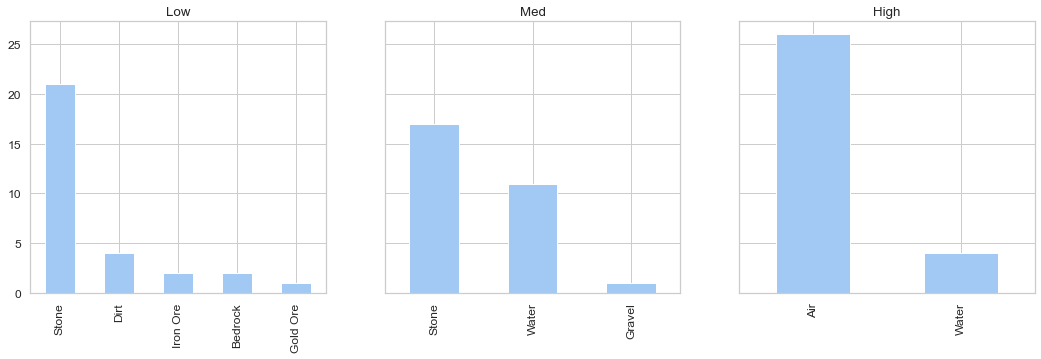

In [59]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

# Axes (Diagramm) Nr. "1"
ax[0].set_title("Low")
df_kern[df_kern.layer=="low"].blockname.value_counts().plot(kind="bar", ax=ax[0])

# Axes (Diagramm) Nr. "2"
ax[1].set_title("Med")
df_kern[df_kern.layer=="mid"].blockname.value_counts().plot(kind="bar", ax=ax[1])

# Axes (Diagramm) Nr. "3"
ax[2].set_title("High")
df_kern[df_kern.layer=="high"].blockname.value_counts().plot(kind="bar", ax=ax[2])

plt.show()

### 4.3. Datenvisualisierung aggregierter Daten
Um in einem Beispiel alles bisher gelernte zusammen zu nehmen, betrachten wir nun die Verteilung des Blöcke "Stone", "Water", "Air", "Gold Ore" ("swag") über die Perzentile hinweg:

In [ ]:
# Stone und alle anderen Blocktypen zu Stone/Other zusammenfassen
df_swag = df_kern.copy()
df_swag.loc[ ~ df_kern.blockname.isin(["Gold Ore", "Water","Air"]), "blockname"] = "Stone/Other"
df_swag = df_swag.loc[:,["perzentil","blockname","blocktyp"]]
dist = df_swag.groupby(["perzentil","blockname"]).agg("count").fillna(0).unstack()
dist.columns = dist.columns.get_level_values(1)

In [ ]:
# Spalten sortieren
dist = dist.loc[:,["Stone/Other","Gold Ore","Water","Air"]]

# Diagramm erzeugen
dist.plot(kind="barh", stacked=True, xticks=range(0,12),
            alpha=0.7, color=["0.1", "#E2B007", "#3444C8","0.8"])
plt.legend(title="Legende", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

---
## 5. Anwendungsbeispiel Kreditvergabe <a id="kapitel4"/>

Wir betrachten im Folgenden einen Datensatz mit Privatkreditvorgängen einer deutschen Bank.  
Hierbei durchlaufen wir dieselbe Prozedur, bauen aber die Grafiken etwas eleganter auf.

Der Datensatz kommt vom Datebankserver und umfasst folgende Merkmalen:
   >  *Age* (numeric)  
   >  *Sex* (text: male, female)  
   >  *Job* (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)  
   >  *Housing* (text: own, rent, or free)  
   >  *Saving accounts* (text - little, moderate, quite rich, rich)  
   >  *Checking account* (text - little, moderate, quite rich, rich)   
   >  *Credit amount* (numeric, in EUR)  
   >  *Duration* (numeric, in month)  
   >  *Purpose* (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others  
   >  *Risk* (Value target - Good or Bad Risk)  

### 5.1. Daten einlesen und aufbereiten

In [ ]:
# Verbindung zum Datenbankserver herstellen

%load_ext sql
%sql sqlite:///data/smi-data.db

# SQL-Abfrage durchführen und Ergebnis in Variable result speichern        
        
result = %sql SELECT * FROM credit_ger

# Aus Result ein DataFrame machen und in Variable df speichern

df = result.DataFrame()
df = df.set_index(["id"])
df.head(5)

In [ ]:
# Spaltenbenennungen vereinfachen
df = df.rename({
    "Age": "age",
    "Sex": "sex",
    "Job": "job",
    "Housing": "housing",
    "Saving_accounts": "savings", 
    "Checking_account": "cash",
    "Credit_amount": "amount",
    "Duration": "duration",
    "Purpose": "purpose",
    "Risk": "risk"
}, axis="columns")

### 5.2. Merkmale untersuchen und visualisieren

In [ ]:
# Deskriptive Statistik der wichtigsten Merkmale

df[['age', 'duration', "amount"]].describe()

#### Untersuchung Kreditausfälle und Alter

In [ ]:
# Globale Kreditausfallquote

# Berechnung mit DataFrame-Filtern

credit_default_rate = df[df.risk=="good"].risk.count() / df.risk.count()
print (credit_default_rate)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle("Kreditausfälle und Alter", fontsize=14)

ax[0].set_title("Kreditverlauf")
sns.histplot(df.risk, ax=ax[0])

ax[1].set_title("Altersverteilung")
sns.histplot(df.age, ax=ax[1])

ax[2].set_title("Altersverteilung nach Kreditausfall")
sns.histplot(x=df.age, hue=df.risk, ax=ax[2], palette="RdYlGn_r", bins=10)

plt.show()

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20,10))

# Verteilungen von Amount, Duration und Age im Histogramm zeigen

plt.suptitle("Verteilungen", fontsize=14)
sns.histplot(df.amount, bins=40, ax=ax[0,0]);
sns.histplot(df.duration, bins=40, ax=ax[0,1], color="salmon");
sns.histplot(df.age, bins=40, ax=ax[0,2], color="darkviolet");

# Ergänzend Boxplots

sns.boxplot(x=df.amount, ax=ax[1,0]);
sns.boxplot(x=df.duration, ax=ax[1,1], color="salmon");
sns.boxplot(x=df.age, ax=ax[1,2], color="darkviolet");

plt.show() 

#### Auffälligkeiten
- Kredite typischerweise 1400-4000 EUR und 1-2 Jahre
- Kredite mit vielen Ausreißerun nach oben (>7500)
- Kreditnehmer Ende 20 bis Anfang 40 

### 5.3. Zusammenhänge untersuchen und visualisieren

In diesem Abschnitt sehen wir uns an, ob einfache Zusammenhänge zwischen Merkmalen zu erkennen sind.

### 5.3.1. Kreuztabellen für nominale Merkmale

Zur Exploration nominale Merkmalzusammenhänge (sex, cash, savings, housing, purpose, risk) können wir mit einfachen Kreuztabellen arbeiten. Ein Beispiel:

In [ ]:
pd.crosstab(df.cash, df.savings)

In [ ]:
pd.crosstab(df.cash, df.savings, normalize="columns")  # Spaltenweise %-Werte, also: Cash-Verteilung über Savings-Kassen

In [ ]:
sns.heatmap(pd.crosstab(df.cash, df.savings, normalize="columns"), annot=True, cmap="YlGnBu")

Was fällt auf? Wer hat am meisten, wer am wenigsten Barvermögen?

### 5.3.2. Betrachtung vieler Merkmale mit PairPlots 

In [ ]:
# Um die ganze Breite nominal/kardinaler Merkmale zu erschlagen, kann das Seaborn PairGrid helfen:

g = sns.PairGrid(df, vars=["sex", "cash", "savings", "housing", "purpose", "risk"], hue="risk")
g.map_diag(sns.histplot, multiple="stack")  # Diagrammtyp auf der Diagonalen der Pair-Matrix
g.map_offdiag(sns.histplot)       # Diagrammtyp für Matrixfelder außerhalb der Diagonalen
g.add_legend(title='Merkmal', frameon=True)

### 5.3.3. Pairplots für metrische Merkmale

Damit die Darstellung noch übersichtlich bleibt, Teilen wir die Merkmale in zwei Mengen, innerhalb derer sich Zusammenhänge vermuten lassen:

In [ ]:
metrische_merkmale = ["risk","amount", "duration", "age"]
sns.pairplot(df.loc[:,metrische_merkmale], hue="risk")
plt.show()

#### Auffälligkeiten
- Amount vs. Duration: Größere Kredite werden in überwiegender Zahl für längere Laufzeiten vergeben.
- Amount vs. Duration: Größere Kredite mit Laufzeit < 2 Jahren fallen sämtlich aus
- Duration vs. Duration: Kredite ab 50 Monaten fallen zu 50% aus

---
### <span style="color:#FF5D02;">Quick Task: Erzeuge das Diagramm duration vs. amount separat um es genauer zu betrachten!</span>
Tip: Verwende die Funktion ```sns.scatterplot()``` ([Dokumentation](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)). Fällt dir etwas auf?

---

Das Merkmale zur Untersichung ist der Kreditzweck ("purpose").

In [ ]:
# Zweck des Kredits vs. Rückzahlungshäufigkeit
pd.crosstab(df.purpose, df.risk, normalize="index")        # normalize: keine absolute Häufigkeit sondern zeilenweise (index) relative Häufigkeit angeben

In [ ]:
# Rückzahlungsquoten scheinen bei 60-70% zu liegen
# Genauere Untersuchung durch Visualisierung
fig, ax = plt.subplots(1,2,figsize=(15,8))
plt.suptitle('Zweck des Kredits')

sns.countplot(y=df.purpose, hue=df.risk, ax=ax[0])
sns.boxplot(y=df.purpose, x=df.amount, hue=df.risk, ax=ax[1])
plt.tight_layout()
plt.show()

#### Auffälligkeiten
- Hoher Zusammenhang zwischen Ausfallrisko und Kreditzweck
- Übermäßig teure Reisekredite (>11k) fallen alle aus
- Höhere Kredite fallen eher aus

In [ ]:
# Zweck des Kredits vs. Wohnsituation und Qualifikation

fig, ax = plt.subplots(1,1,figsize=(18,8))
plt.suptitle('Housing und Qualifikation')

sns.violinplot(x=df.housing, y=df.job, hue=df.risk, split=True);

#### Auffälligkeiten
- Geringe Qualifikation, kein Wohneigentum oder Mietverhältnis ist eine problematische Kombination
- Bei Wohneigentum generell höhere Rückzahlungshäufigkeit, insbl. mit Berufsausbildung ("skilled", job = 2)
- In höchster Qualifikationsstufe keine Wechselwirkung mit Wohnsituation erkennbar

---
### <span style="color:#FF5D02;">Aufgabe: Exploration weiterer Merkmale</span>
Untersuche die Merkmale ```sex```, ```savings``` und ```cash``` einzeln und im Zusammenhang mit der Kreditrückzahlungsquote!  

Führe die Untersuchung sowohl tabellarisch als auch grafisch durch.